In [1]:
import os
import random
import sys
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import umap
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    validation_curve,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    RobustScaler,
)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"  # Also affect subprocesses

ConvergenceWarning('ignore')
warnings.filterwarnings('ignore')
sns.set()
sns.set_theme(style="white")

np.random.seed(2)
random.seed(2)

In [2]:
data = pd.read_csv("../data/raw/loans-dataset-german.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A11     999 non-null    object
 1   6       999 non-null    int64 
 2   A34     999 non-null    object
 3   A43     999 non-null    object
 4   1169    999 non-null    int64 
 5   A65     999 non-null    object
 6   A75     999 non-null    object
 7   4       999 non-null    int64 
 8   A93     999 non-null    object
 9   A101    999 non-null    object
 10  4.1     999 non-null    int64 
 11  A121    999 non-null    object
 12  67      999 non-null    int64 
 13  A143    999 non-null    object
 14  A152    999 non-null    object
 15  2       999 non-null    int64 
 16  A173    999 non-null    object
 17  1       999 non-null    int64 
 18  A192    999 non-null    object
 19  A201    999 non-null    object
 20  1.1     999 non-null    int64 
dtypes: int64(8), object(13)
memory usage: 164.0+ KB


In [3]:
new_columns = [f"C{ii + 1}" for ii in range(len(data.columns))]
data.columns = new_columns

In [4]:
categorical_features = {
    'C1': 'status_account',
    'C3': 'credit_history',
    'C4': 'purpose_credit',
    'C6': 'saving_account',
    'C7': 'present_employment_since',
    'C9': 'personal_status',
    'C10': 'other_debtors',
    'C12': 'property_status',
    'C14': 'other_installment_plans',
    'C15': 'housing',
    'C17': 'job',
    'C19': 'has_telephone',
    'C20': 'is_foreign_worker',
}

numerical_features = {
    'C2': 'duration',
    'C5': 'credit_amount',
    'C8': 'percentage_rate_income',
    'C11': 'present_residence_since',
    'C13': 'age_in_years',
    'C16': 'number_credits',
    'C18': 'num_liable_people',
}

# Target variable
target = {'C21': 'y'}
data = data.rename(columns=categorical_features | numerical_features | target)

In [5]:
data.head()

,status_account,duration,credit_history,purpose_credit,credit_amount,saving_account,present_employment_since,percentage_rate_income,personal_status,other_debtors,...,property_status,age_in_years,other_installment_plans,housing,number_credits,job,num_liable_people,has_telephone,is_foreign_worker,y
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
2,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
3,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
4,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1


In [6]:
label_encoder = LabelEncoder()

X = data.drop(columns=['y'], inplace=False)
y = data[['y']]

### There are no missing values in dataset - no need to fill them

### All numerical features  I scaled using percentile normalization (RobustScaler) for faster convergence of model.


In [7]:
numeric_transformer = RobustScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, list(numerical_features.values())),
        ('categorical', categorical_transformer,
         list(categorical_features.values()))
    ]
)

X_transformed_numpy = preprocessor.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed_numpy)

y_transformed = label_encoder.fit_transform(y)
y_transformed = pd.DataFrame(y_transformed, columns=['y'])

### PCA analysis

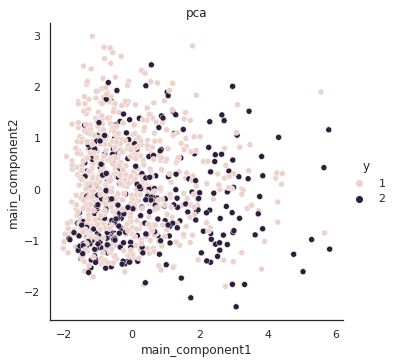

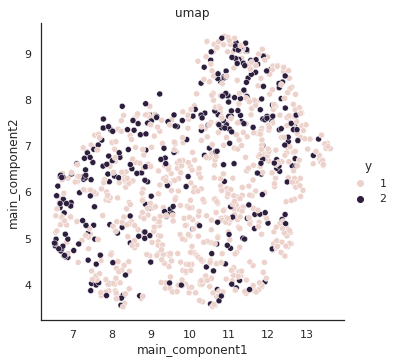

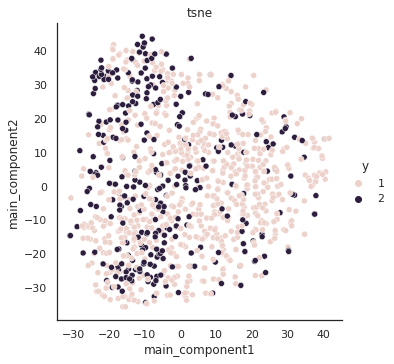

In [8]:
visualizers = {
    "pca": PCA(n_components=2),
    'umap': umap.UMAP(),
    'tsne': TSNE(),
}

for name, reducer in visualizers.items():
    main_components = pd.DataFrame(
        data=reducer.fit_transform(X_transformed),
        columns=["main_component1", "main_component2"])

    main_components['y'] = data['y']

    vis_plot = sns.relplot(x="main_component1",
                           y='main_component2', hue='y', data=main_components)
    vis_plot.set(title=name)
    vis_plot.savefig(f"{name}.png")

Num features in X_transformed: 61


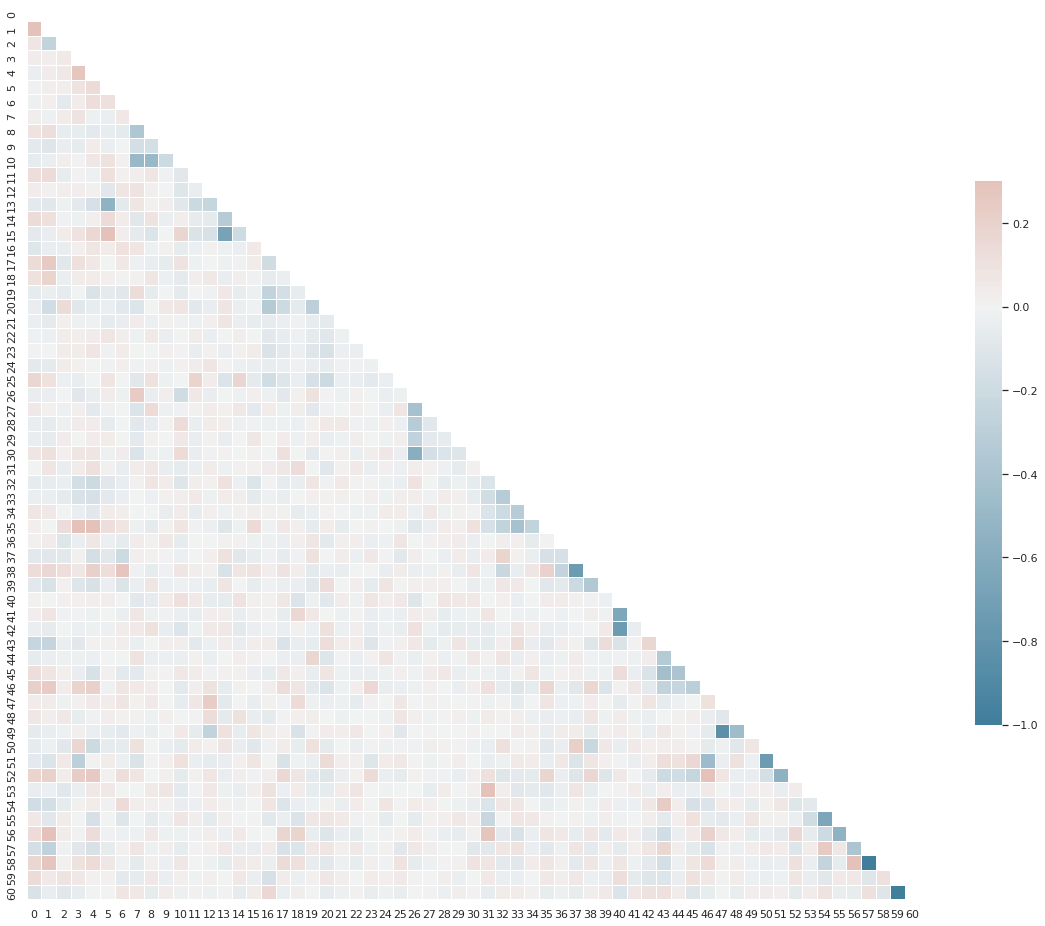

In [9]:
print(f"Num features in X_transformed: {X_transformed.shape[1:][0]}")


def plot_correlation_matrix(df: pd.DataFrame):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                       square=True, linewidths=.5, cbar_kws={"shrink": .5})


corr_plot = plot_correlation_matrix(X_transformed)
corr_plot.figure.savefig("corr.png")

In [10]:
def top_corr_features(df: pd.DataFrame, threshold: float) -> pd.DataFrame:
    df_corr = df.corr()
    df_filtered = df_corr[((df_corr > threshold) | (
            df_corr < - threshold)) & (df_corr != 1.0)]
    df_flatten = df_filtered.unstack().sort_values().drop_duplicates()
    return df_flatten[:-1]


print("Top correlated features:")
print(top_corr_features(X_transformed, threshold=0.80))

Top correlated features:
57  58   -1.000000
59  60   -1.000000
47  49   -0.840518
dtype: float64


### We need to exclude highly correlated features because it could cause multicollinearity and this could cause inability to converge.
### There are only 3 feature columns out of 61  that strongly correlate with each other - so they would be a big problem for linear regression.

### Finding the best degree of model

smallest val loss at 1


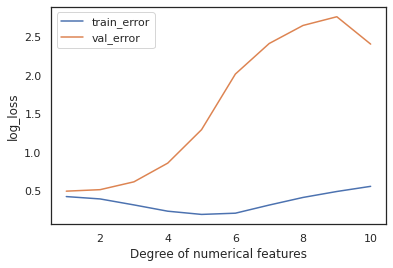

In [11]:
train_indices, test_indices = train_test_split(list(range(len(data))), test_size=0.3, stratify=y_transformed)

X_transformed_train = X_transformed.iloc[train_indices]
X_transformed_test = X_transformed.iloc[test_indices]
y_transformed_train = y_transformed.iloc[train_indices]
y_transformed_test = y_transformed.iloc[test_indices]

degrees = list(range(1, 11))

numeric_poly_features = ColumnTransformer(transformers=[
    ('numerical', PolynomialFeatures(), list(range(len(numerical_features)))),
], remainder='passthrough')

pipe = Pipeline(steps=[
    ("poly", numeric_poly_features),
    ("logistic", LogisticRegression(max_iter=500, n_jobs=-1))
])

train_errors, val_errors = validation_curve(pipe, X_transformed_train, y_transformed_train,
                                            param_name="poly__numerical__degree",
                                            param_range=degrees,
                                            cv=7,
                                            scoring='neg_log_loss',
                                            n_jobs=-1)

results = pd.DataFrame({
    "train_error": -train_errors.mean(axis=1),
    'val_error': -val_errors.mean(axis=1),
})
plt.plot(degrees, results)
plt.xlabel("Degree of numerical features")
plt.ylabel("log_loss")
plt.legend(results.columns, loc='upper left')

print(f"smallest val loss at {np.argmin(results.val_error) + 1}")

### I think that there is no underfitting at each degree, but we could see that validation loss greatly diverges from the 3 degree - that's overfitting.
### So, optimal degree of numerical features is 2. We will use it in GridSearch.

In [12]:
param_grid = {
    "poly__numerical__degree": [2],
    "logistic__penalty": ['l1', 'l2'],
    "logistic__solver": ['lbfgs', 'liblinear'],
    'logistic__C': np.logspace(0.01, 20, 40),
}

grid_search = GridSearchCV(pipe, param_grid=param_grid,
                           cv=7, scoring="neg_log_loss", n_jobs=-1)

grid_search.fit(X_transformed_train, y_transformed_train)
best_param = grid_search.best_params_
print(f"best_param: {best_param}")

min_val_score = -grid_search.score(X_transformed_test, y_transformed_test)
print(f"min val score: {min_val_score}")

best_param: {'logistic__C': 1.023292992280754, 'logistic__penalty': 'l1', 'logistic__solver': 'liblinear', 'poly__numerical__degree': 2}
min val score: 0.5173741485983512


In [13]:
def is_male(df):
    return (df.personal_status == 'A91') | (df.personal_status == "A93") | (df.personal_status == "A94")

test_data = data.iloc[test_indices]
male_test_data = test_data[is_male(test_data)]
female_test_data = test_data[~is_male(test_data)]

In [14]:
print(f"Male shape: {male_test_data.shape}, "
      f"female shape: {female_test_data.shape}")

Male shape: (197, 21), female shape: (103, 21)


In [15]:
male_test_data.head()

,status_account,duration,credit_history,purpose_credit,credit_amount,saving_account,present_employment_since,percentage_rate_income,personal_status,other_debtors,...,property_status,age_in_years,other_installment_plans,housing,number_credits,job,num_liable_people,has_telephone,is_foreign_worker,y
320,A11,24,A32,A43,1938,A61,A72,4,A91,A101,...,A122,32,A143,A152,1,A173,1,A191,A201,2
798,A12,9,A32,A40,1549,A65,A72,4,A93,A101,...,A121,35,A143,A152,1,A171,1,A191,A201,1
559,A11,24,A32,A41,2964,A65,A75,4,A93,A101,...,A124,49,A141,A153,1,A173,2,A192,A201,1
178,A11,21,A34,A40,571,A61,A75,4,A93,A101,...,A121,65,A143,A152,2,A173,1,A191,A201,1
715,A14,30,A34,A43,3077,A65,A75,3,A93,A101,...,A123,40,A143,A152,2,A173,2,A192,A201,1


In [16]:
female_test_data.head()

,status_account,duration,credit_history,purpose_credit,credit_amount,saving_account,present_employment_since,percentage_rate_income,personal_status,other_debtors,...,property_status,age_in_years,other_installment_plans,housing,number_credits,job,num_liable_people,has_telephone,is_foreign_worker,y
776,A11,18,A32,A43,3509,A61,A74,4,A92,A103,...,A121,25,A143,A152,1,A173,1,A191,A201,1
243,A14,12,A31,A48,3447,A63,A73,4,A92,A101,...,A121,35,A143,A152,1,A172,2,A191,A201,1
914,A12,48,A30,A410,18424,A61,A73,1,A92,A101,...,A122,32,A141,A152,1,A174,1,A192,A202,2
85,A12,18,A34,A42,1295,A61,A72,4,A92,A101,...,A122,27,A143,A152,2,A173,1,A191,A201,1
639,A11,18,A32,A46,750,A61,A71,4,A92,A101,...,A121,27,A143,A152,1,A171,1,A191,A201,2


In [17]:
X_male = male_test_data.drop(columns=['y'], inplace=False)
y_male = male_test_data[['y']]

X_female = female_test_data.drop(columns=['y'], inplace=False)
y_female = female_test_data[['y']]

X_male_transformed = preprocessor.transform(X_male)
y_male_transformed = label_encoder.transform(y_male)

X_female_transformed = preprocessor.transform(X_female)
y_female_transformed = label_encoder.transform(y_female)

male_accuracy = accuracy_score(y_true=y_male_transformed,
                               y_pred=grid_search.predict(X_male_transformed))
female_accuracy = accuracy_score(y_true=y_female_transformed,
                                 y_pred=grid_search.predict(X_female_transformed))

print(f"accuracy score for male: {male_accuracy}, "
      f"number of males: {len(X_male)}")
print(f"accuracy score for female: {female_accuracy}, "
      f"number of females: {len(X_female)}")

accuracy score for male: 0.766497461928934, number of males: 197
accuracy score for female: 0.7281553398058253, number of females: 103


### Accuracy for male part of group is greater than the females because there are more male examples than females in dataset

